# **Behavior cloning**

In [ ]:
%load_ext tensorboard

In [2]:
# Clear any logs from previous runs
!rm -rf ./logs/

## **Setup**

In [35]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
import matplotlib.pyplot as plt
import os

DATA_DIR = './data/'
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
KEEP_PROB = 0.5
EPOCHS = 10
BATCH_SIZE = 32

device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

print("TensorFlow version: ", tf.__version__)

Found GPU at: /device:GPU:0
TensorFlow version:  2.3.0


## **Load the driving log file**

In [ ]:
!unzip '/content/drive/My Drive/Colab Notebooks/CarND/CarND-Behavioral-Cloning/data.zip'

## **Prepare the data**

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv(os.path.join(DATA_DIR, 'driving_log.csv'))

lines = df.to_dict('index')

# CSV line split to train and validation 
train_samples, valid_samples = train_test_split(lines, test_size=0.2)

n_train= len(train_samples)
n_valid = len(valid_samples)

print('Number of train data : ', n_train)
print('Number of validation data : ', n_valid)

Number of train data :  6428
Number of validation data :  1608


## **Sample images**

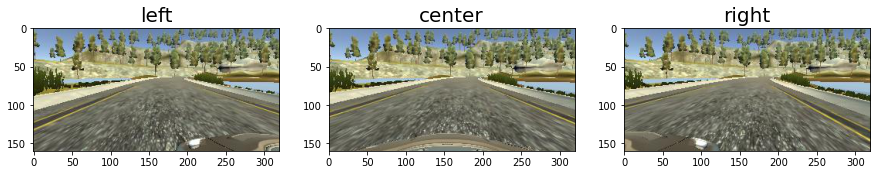

In [8]:
import random

index = np.sum(random.sample(range(0, n_train),1))
line = train_samples[index]

fig, axs = plt.subplots(1,3, figsize=(15,5))

left_img_path = line['left'].strip()
center_img_path = line['center'].strip()
right_img_path = line['right'].strip()

left_img_path = os.path.join(DATA_DIR, left_img_path)
left_img = plt.imread(left_img_path)
axs[0].imshow(left_img.squeeze())
axs[0].set_title('left',fontsize=20)

center_img_path = os.path.join(DATA_DIR, center_img_path)
center_img = plt.imread(center_img_path)
axs[1].imshow(center_img.squeeze())
axs[1].set_title('center',fontsize=20)

right_img_path = os.path.join(DATA_DIR, right_img_path)
right_img = plt.imread(right_img_path)
axs[2].imshow(right_img.squeeze())
axs[2].set_title('right',fontsize=20)

plt.show()

## **Preprocessing (Crop, Resize, YUV convert)**

In [9]:
import cv2

def preprocess(image):
    # remove the sky and the car front
    image = image[50:-20, :, :] 
    # Resize the image to the input shape used by the network model
    image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)
    #Convert the image from RGB to YUV (This is what the NVIDIA model does)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

    return image

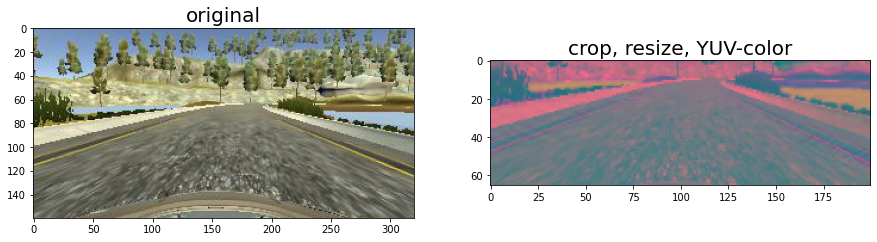

In [10]:
sample_image = plt.imread(center_img_path)
process_image = preprocess(sample_image)

fig, axs = plt.subplots(1,2, figsize=(15, 5))

axs[0].imshow(sample_image.squeeze())
axs[0].set_title('original',fontsize=20)

axs[1].imshow(process_image.squeeze())
axs[1].set_title('crop, resize, YUV-color',fontsize=20)

plt.show()

## **Data Distribution Flattening**

new_train_samples =  1445


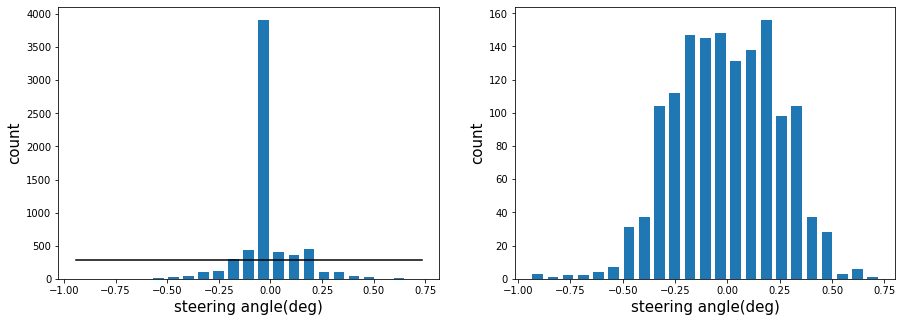

In [24]:
# Get steering angles from train samples
angles = list(item['steering'] for item in train_samples)

# Plot the distribution histogram
fig, axs = plt.subplots(1,2, figsize=(15, 5))

# print a histogram to see which steering angle ranges are most overrepresented
num_bins = 23
avg_samples_per_bin = len(angles)/num_bins
hist, bins = np.histogram(angles, num_bins)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
axs[0].bar(center, hist, align='center', width=width)
axs[0].plot((np.min(angles), np.max(angles)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
axs[0].set_xlabel('steering angle(deg)', fontsize = '15')
axs[0].set_ylabel('count', fontsize = '15')

# determine keep probability for each bin: if below avg_samples_per_bin, keep all; otherwise keep prob is proportional
# to number of samples above the average, so as to bring the number of samples for that bin down to the average
keep_probs = []
target = avg_samples_per_bin * .5
for i in range(num_bins):
    if hist[i] < target:
        keep_probs.append(1.)
    else:
        keep_probs.append(1./(hist[i]/target))
remove_list = []
for i in range(len(angles)):
    for j in range(num_bins):
        if angles[i] > bins[j] and angles[i] <= bins[j+1]:
            # delete from X and y with probability 1 - keep_probs[j]
            if np.random.rand() > keep_probs[j]:
                remove_list.append(i)

# Change the new train data 
new_train_samples = np.delete(train_samples, remove_list, axis=0)
new_nTrain = len(new_train_samples) 
print('new_train_samples = ', new_nTrain)
angles = np.delete(angles, remove_list)

# print histogram again to show more even distribution of steering angles
hist, bins = np.histogram(angles, num_bins)
axs[1].bar(center, hist, align='center', width=width)
axs[1].set_xlabel('steering angle(deg)', fontsize = '15')
axs[1].set_ylabel('count', fontsize = '15')

plt.show()

## **Set data augmentation**

In [21]:
import matplotlib.image as mpimg
import sklearn

np.random.seed(0)

def load_image(data_dir, image_file):
    """
    Load RGB images from a file
    """
    return mpimg.imread(os.path.join(data_dir, image_file.strip()))

def choose_image(data_dir, line):
    """
    Randomly choose an image from the center, left or right, and adjust
    the steering angle.
    """
    choice = np.random.choice(3)
    if choice == 0:
        return load_image(data_dir, line['left']), line['steering'] + 0.2
    elif choice == 1:
        return load_image(data_dir, line['right']), line['steering'] - 0.2
    return load_image(data_dir, line['center']), line['steering']

def random_flip(image, steering_angle):
    """
    Randomly flipt the image left <-> right, and adjust the steering angle.
    """
    image = cv2.flip(image, 1)
    steering_angle = -steering_angle
    return image, steering_angle

def random_translate(image, steering_angle, range_x, range_y):
    """
    Randomly shift the image virtially and horizontally (translation).
    """
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    steering_angle += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, steering_angle

def random_brightness(image):
    """
    Randomly adjust brightness of the image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def augument(data_dir, line, range_x=100, range_y=10):
    """
    Generate an augumented image and adjust steering angle.
    (The steering angle is associated with the center image)
    """
    image, steering_angle = choose_image(data_dir, line)
    image, steering_angle = random_flip(image, steering_angle)
    image, steering_angle = random_translate(image, steering_angle, range_x, range_y)
    image = random_brightness(image)
    return image, steering_angle

### **Flip Image**

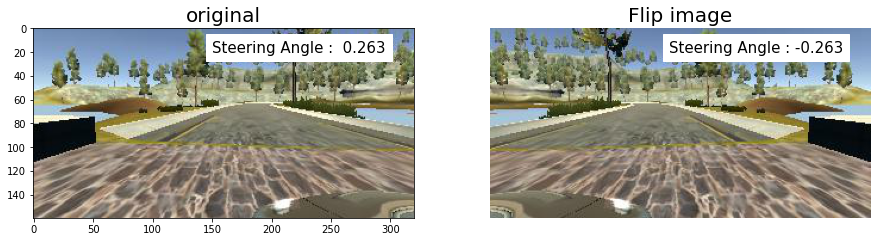

In [25]:
index = np.sum(random.sample(range(0, new_nTrain),1))

original_image = load_image(DATA_DIR, new_train_samples[index]['left'])
steering_angle = new_train_samples[index]['steering']
flip_image, flip_steering_angle = random_flip(original_image, steering_angle)   
translate_image, translate_steering_angle = random_translate(original_image, steering_angle, range_x=100, range_y=100)   

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].imshow(original_image)
axs[0].set_title('original',fontsize=20)
axs[0].axis('on')
axs[0].text(150,20,'Steering Angle : {: 0.3f}'.format(steering_angle),
            backgroundcolor = 'white', fontsize=15)

axs[1].imshow(flip_image)
axs[1].set_title('Flip image',fontsize=20)
axs[1].axis('off')
axs[1].text(150,20,'Steering Angle : {: 0.3f}'.format(flip_steering_angle),
            backgroundcolor = 'white', fontsize=15)

plt.show()

### **Translate imaged**

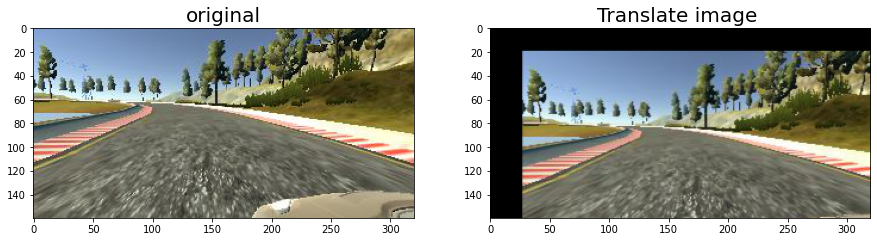

In [28]:
index = np.sum(random.sample(range(0, new_nTrain),1))

original_image = load_image(DATA_DIR, new_train_samples[index]['left'])
translate_image, translate_steering_angle = random_translate(original_image, steering_angle, range_x=100, range_y=100)   

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].imshow(original_image)
axs[0].set_title('original',fontsize=20)
axs[0].axis('on')

axs[1].imshow(translate_image)
axs[1].set_title('Translate image ',fontsize=20)
axs[1].axis('on')

plt.show()

### **Bright Image**

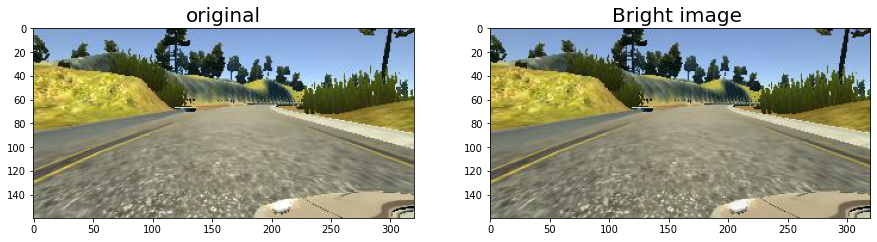

In [29]:
index = np.sum(random.sample(range(0, new_nTrain),1))

original_image = load_image(DATA_DIR, new_train_samples[index]['left'])
bright_image = random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].imshow(original_image)
axs[0].set_title('original',fontsize=20)
axs[0].axis('on')

axs[1].imshow(bright_image)
axs[1].set_title('Bright image ',fontsize=20)
axs[1].axis('on')

plt.show()

## **Get a generator not to store all the values in memory**

In [30]:
from sklearn.utils import shuffle

def generator(data_dir, samples, batch_size=BATCH_SIZE, is_training='True'):
    """
    Generate the required images and measurments for training/
    """
    images = []
    angles = []

    while 1: # Loop forever so the generator never terminates
        samples = shuffle(samples)
        batch_samples = samples[0:batch_size]

        #for offset in range(0, num_samples, batch_size):
        for index, batch_line in enumerate(batch_samples):
            # argumentation
            if is_training and np.random.rand() < 0.6:
                image, steering_angle = augument(data_dir, batch_line)
            else:
                image = load_image(data_dir, batch_line['center'])
                steering_angle = batch_line['steering']
            # Add the images and steering angles to the list
            images.append(preprocess(image))
            angles.append(steering_angle)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield X_train, y_train

## **Base Model and Adjustments**

The project instructions from Udacity suggest starting from a known self-driving car model and provided a link to the [nVidia model](https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf) and later in the student forum, the [comma.ai model](https://github.com/commaai/research/blob/master/train_steering_model.py)) 

First, I reproduced this model as depicted in the image - including image normalization using a Keras Lambda function, with three 5x5 convolution layers, two 3x3 convolution layers, and three fully-connected layers - and as described in the paper text - including converting from RGB to YUV color space, and 2x2 striding on the 5x5 convolutional layers. The paper does not mention any sort of activation function or means of mitigating overfitting, so I began with Relu activation functions on each fully-connected layer, and dropout (with a keep probability of 0.5) between the two sets of convolution layers and after the first fully-connected layer. The Adam optimizer was chosen with default parameters and the chosen loss function was mean squared error (MSE). The final layer (depicted as "output" in the diagram) is a fully-connected layer with a single neuron to determine the steering angle


In [34]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Cropping2D

model = Sequential()
model.add(Lambda(lambda x: x/127.5-1.0, input_shape=INPUT_SHAPE))
model.add(Conv2D(24,kernel_size=(5, 5), activation='relu', strides=(2, 2), padding='Valid'))
model.add(Conv2D(36,kernel_size=(5, 5), activation='relu', strides=(2, 2), padding='Valid'))
model.add(Conv2D(48,kernel_size=(5, 5), activation='relu', strides=(2, 2), padding='Valid'))
model.add(Conv2D(64,kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64,kernel_size=(3, 3), activation='relu'))
model.add(Dropout(KEEP_PROB))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 18, 64)        

## **Build Model**

In [36]:
from math import ceil

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint('model-{epoch:03d}.h5',
                             monitor='val_loss',
                             verbose=0,
                             save_best_only='true',
                             mode='auto')

earlystopping = EarlyStopping(monitor='val_loss', 
                            patience=0, 
                            verbose=0, 
                            mode='auto')


# Mean Squared Error(MSE) for the loss function and Adam optimizer
model.compile(loss='mse', optimizer='adam')

# Training data generator
train_generator = generator(DATA_DIR, new_train_samples, BATCH_SIZE, 'True')

# Validation data generator
valid_generator = generator(DATA_DIR, valid_samples, BATCH_SIZE, 'False')

logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')

history_object = model.fit(train_generator, 
                  steps_per_epoch=ceil(n_train/BATCH_SIZE),
                  validation_data=valid_generator, 
                  validation_steps=ceil(n_valid/BATCH_SIZE),
                  epochs = EPOCHS,
                  callbacks=[checkpoint],# earlystopping],
                  verbose=1,
                  shuffle = 1)

with open(os.path.join(DATA_DIR, 'model.json'), 'w') as file:
    file.write(model.to_json())

Epoch 1/10
201/201 [==============================] - 20s 98ms/step - loss: 0.0076 - val_loss: 0.0399
Epoch 2/10
201/201 [==============================] - 37s 186ms/step - loss: 0.0024 - val_loss: 0.0283
Epoch 3/10
201/201 [==============================] - 55s 273ms/step - loss: 0.0019 - val_loss: 0.0311
Epoch 4/10
201/201 [==============================] - 73s 363ms/step - loss: 0.0011 - val_loss: 0.0361
Epoch 5/10
201/201 [==============================] - 90s 450ms/step - loss: 7.6478e-04 - val_loss: 0.0344
Epoch 6/10
201/201 [==============================] - 108s 536ms/step - loss: 6.8363e-04 - val_loss: 0.0317
Epoch 7/10
201/201 [==============================] - 125s 623ms/step - loss: 5.8454e-04 - val_loss: 0.0304
Epoch 8/10
201/201 [==============================] - 143s 710ms/step - loss: 4.9404e-04 - val_loss: 0.0282
Epoch 9/10
201/201 [==============================] - 160s 797ms/step - loss: 4.1763e-04 - val_loss: 0.0275
Epoch 10/10
201/201 [=============================

## **plot the training and validation loss for each epoch**

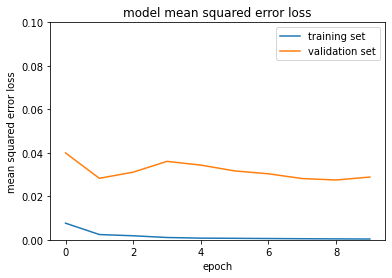

In [37]:
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.ylim(0, 0.1)
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

## **Load tensorboard**

In [ ]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs